In [2]:
%matplotlib inline
import ipykernel
import numpy as np
from astropy.io import fits
import astropy.units as units
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc
from scipy.interpolate import interp1d
from scipy import stats
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.mixture import GMM

In [3]:
rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=20)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=1.5)
rc('axes', linewidth=1.5)
rc('axes', facecolor='f9f9f9')
rc('axes', axisbelow=True)
rc('xtick', direction='in')
rc('ytick', direction='in')
rc('grid', color='cbcbcb')
rc('grid', linestyle='-')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)


# Distribution of the sources in the sky

1. Start with the Gaia sources, Xmatched with 2MASS (Xmatch performed on the Archive, requesting in particular that the separation between the crossmatched sources is < 1 arsec). 

2. The second step is to select the sources applying two photometric selection; the first one is to select sources with good photometry, the second one to select those with no infrared excess.

In [6]:
path = '/data1/Data/Zari+17/'
hdu = fits.open(path + 'XMatch_2MASS_crosslt1arsec.fits')
gaia = hdu[1].data

### Photometric Selection

gaia = gaia[gaia['ph_qual'] == 'AAA']
ir = ((gaia['j_m'] - gaia['h_m']) < -1.05*(gaia['h_m'] - gaia['ks_m']) + 0.97) & \
                   (gaia['j_m'] < 15.) & (gaia['j_m'] - gaia['h_m'] < 0.74) & \
                   (gaia['h_m'] - gaia['ks_m'] > -0.2)  & \
                   (gaia['h_m'] - gaia['ks_m'] < 0.43 )     
            
gaia = gaia[ir]

In [7]:
print('Final Number of sources:', len(gaia))

Final Number of sources: 1450911


In [8]:
l, b = gaia['l'], gaia['b']


3.Then I want to study the distribution in the sky of the sources. First I compute the density of all the sources I selected above. Then I compute the density of the young sources. I subtract the two, and compute the significance levels of the over-densities.

4.The final step is to select the sources within S = 2 (S as defined in the paper).

In [70]:
### Kernel for all the sources (this takes a while)

xmin, xmax = 190.,220.
ymin, ymax = -30.,-5.

X = np.vstack([l, b]).T
deg2rad = np.pi/180.
X = X*deg2rad

kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(X)

Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 250)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*deg2rad

log_dens_field = kde.score_samples(grid).T
log_dens_field = log_dens_field.reshape(X.shape)

In [71]:
dens_field = np.exp(log_dens_field)

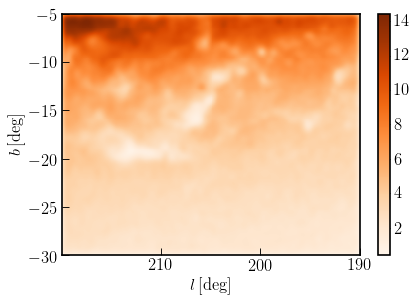

In [388]:
plt.imshow(np.rot90(dens_field.T), extent = [xmin, xmax, ymin, ymax], aspect =  'auto', 
          cmap = 'Oranges')
plt.axis([219.9, 190, -30, -5])
plt.colorbar()
plt.xlabel(r'$l \, \mathrm{[deg]}$')
plt.ylabel(r'$b \, \mathrm{[deg]}$')

In [312]:
### Average KDE of all the sources
avg_kde = np.mean(dens_field, axis=1)
dens_avg = np.zeros((300, 250))
for i in range(250):
    dens_avg[:, i] = avg_kde[i]

In [383]:
### Compute std for the average KDE
std_avg = np.std(dens_field, axis = 1)
dens_std = np.zeros((300, 250))
for i in range(250):
    dens_std[:, i] = std_avg[i]


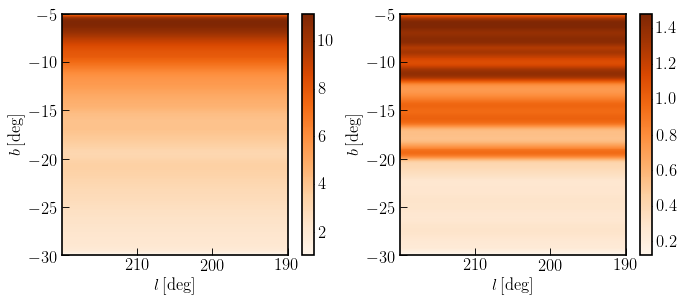

In [384]:
### And plot!

plt.figure(figsize=(10, 4))
plt.subplot(121)
im =plt.imshow(np.rot90(dens_avg), extent = [xmin, xmax, ymin, ymax], aspect =  'auto', 
          cmap = 'Oranges')
plt.axis([219.9, 190, -30, -5])
plt.colorbar(im)
plt.xlabel(r'$l \, \mathrm{[deg]}$')
plt.ylabel(r'$b \, \mathrm{[deg]}$')

plt.subplot(122)
st =plt.imshow(np.rot90(dens_std), extent = [xmin, xmax, ymin, ymax], aspect =  'auto', 
          cmap = 'Oranges')
plt.axis([219.9, 190, -30, -5])
plt.colorbar(st)
plt.xlabel(r'$l \, \mathrm{[deg]}$')
plt.ylabel(r'$b \, \mathrm{[deg]}$')


To separate the young sources, I use Eq. (6) in the paper.

In [22]:
wyoungFaint = np.where((gaia['phot_g_mean_mag'] <  2.5*(gaia['phot_g_mean_mag']-gaia['j_m']) + 10.5) & \
                (gaia['phot_g_mean_mag'] > 14.25))
                         

wyoungBright =  np.where((gaia['phot_g_mean_mag'] <  2.9*(gaia['phot_g_mean_mag']-gaia['j_m']) + 9.9) & \
                (gaia['phot_g_mean_mag'] <= 14.25))
                 
youngFaint = gaia[(wyoungFaint)] 
youngBright = gaia[wyoungBright]


gaia_young = np.concatenate((youngFaint, youngBright))


In [33]:
### Kernel of the young sources

xmin, xmax = 190.,220.
ymin, ymax = -30.,-5.

lyoung, byoung = gaia_young['l'], gaia_young['b']
Xyoung = np.vstack([lyoung, byoung]).T
deg2rad = np.pi/180.
Xyoung = Xyoung*deg2rad

kde = KernelDensity(kernel='gaussian', bandwidth=0.3*deg2rad, metric = 'haversine').fit(Xyoung)

Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 250)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*deg2rad

log_dens_field_young = kde.score_samples(grid).T
log_dens_field_young = log_dens_field_young.reshape(X.shape)

dens_field_young = np.exp(log_dens_field_young)

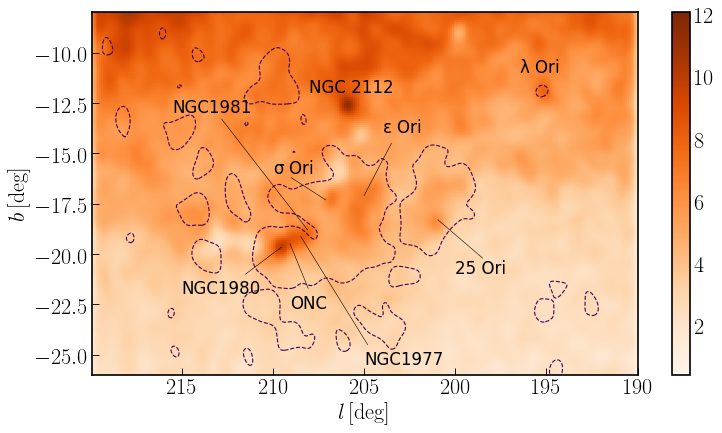

In [612]:
### Density of young sources 
### Note that the TGAS contour levels are defined below.

plt.figure(figsize=(11, 6))
im  = plt.imshow(np.rot90(dens_field_young.T), extent = [xmin, xmax, ymin, ymax], aspect =  'auto', 
          cmap = 'Oranges')
plt.contour(Xsamples, Ysamples,normalized_density_tgas,
                          levels = [3], color ='gray', linewidths = 1, linestyles = 'dashed')
plt.axis([219.9, 190, -26, -8])


rc('text', usetex= False)
rc('font', family='sans-serif', weight = 'normal', size=15)
plt.text(215., -22., 'NGC1980', fontsize = 15, family ='sans-serif')
plt.plot([211.5, 209.52], [-21., -19.65], 'k-', lw = 0.5)
plt.text(215.5, -13., 'NGC1981', fontsize = 15, family ='sans-serif')
plt.plot([212.8, 208.09], [-13.3, -18.8 ], 'k-', lw =0.5)
plt.text(200, -21., '25 Ori', color= 'k', fontsize = 15, family ='sans-serif')
plt.plot([198.5, 200.946],[-20.2, -18.3], 'k-', lw = 0.5)  

plt.text(204., -14., '$\mathrm{\epsilon}$ Ori', fontsize = 15, family ='sans-serif')
plt.plot([203.5, 205.],[-14.5, -17.1], 'k-', lw = 0.5)
plt.text(210, -16., '$\mathrm{\sigma}$ Ori', fontsize = 15, family ='sans-serif')
plt.plot([209., 207.1], [-16.2, -17.31], 'k-', lw = 0.5)
plt.text(196.5, -11. , '$\mathrm{\lambda}$ Ori', fontsize = 15, family ='sans-serif')
plt.text(208, -12, 'NGC 2112', fontsize = 15, family ='sans-serif')
plt.text(209.06, -22.7, 'ONC', fontsize = 15, family ='sans-serif')
plt.plot([208.06, 209.06], [-21.7, -19.48], 'k-', lw = 0.5)
plt.text(205, -25.5 , 'NGC1977', fontsize = 15, family ='sans-serif')
plt.plot([204.8, 208.47], [-24.5, -19.12], 'k-', lw = 0.5)


rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=20)
plt.colorbar(im)
plt.xlabel(r'$l \, \mathrm{[deg]}$')
plt.ylabel(r'$b \, \mathrm{[deg]}$')


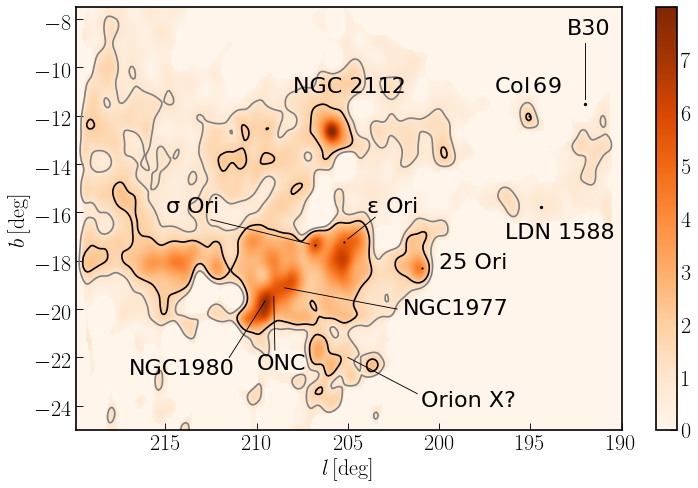

In [591]:
### Plot difference between the two density maps

plt.figure(figsize=(11, 7))
im = plt.imshow(( np.rot90(dens_field_young.T)- np.rot90(dens_avg))/np.rot90(dens_std), 
           extent = [xmin, xmax, ymin, ymax], aspect =  'auto', interpolation = 'gaussian',
          cmap = 'Oranges', vmin = 0)
d =  (np.rot90(dens_field_young.T)- np.rot90(dens_avg))/np.rot90((dens_std))
twosigma = plt.contour(np.rot90(d.T), 
            colors = ['gray', 'k'],
            extent=[xmin, xmax, ymin, ymax],
            levels = [1,2], lw = 2)

#### Symbols
plt.plot(200.95, -18.29, 'ko', ms = 2, markeredgecolor = 'None', label = '25 Ori')
plt.plot(205.21, -17.24 , 'ko', ms = 2, markeredgecolor = 'None', label = '$\mathrm{\epsilon}$ Ori')
plt.plot(206.81, -17.33, 'ko', ms = 2, markeredgecolor = 'None', label = '$\mathrm{\sigma}$ Ori')
plt.plot(195.05, -11.99, 'ko', ms = 2, markeredgecolor = 'None', label ='$\mathrm{\lambda}$ Ori')

### Text
rc('text', usetex= False)
plt.text(217., -22.7, 'NGC1980', fontsize = 20, family ='sans-serif')
plt.plot([211.5, 209.52], [-22., -19.65], 'k-', lw = 0.8)
plt.text(200, -18.29, '25 Ori', fontsize = 20, family ='sans-serif')
plt.text(204., -16., '$\mathrm{\epsilon}$ Ori', fontsize = 20, family ='sans-serif')
plt.plot([203.5, 205.],[-16.2, -17.1], 'k-', lw = 0.8)
plt.text(215, -16., '$\mathrm{\sigma}$ Ori', fontsize = 20, family ='sans-serif')
plt.plot([212.5, 207.1], [-16.3, -17.31], 'k-', lw = 0.8)
plt.text(197., -11. , '$\mathrm{Col \, 69}$', fontsize = 20, family ='sans-serif')
plt.text(208, -11, 'NGC 2112', fontsize = 20, family ='sans-serif')
plt.text(210.0, -22.5, 'ONC', fontsize = 20, family ='sans-serif')
plt.plot([209., 209.06], [-21.7, -19.48], 'k-', lw = 0.8)
plt.text(202, -20.2 , 'NGC1977', fontsize = 20, family ='sans-serif')
plt.plot([202.3, 208.47], [-20., -19.12], 'k-', lw = 0.8)

plt.text(193, -8.6 , 'B30', fontsize = 20, family ='sans-serif')
plt.plot([192., 192], [-9., -11.3], 'k-', lw = 0.8)
plt.plot(192., -11.5, 'ko', ms = 3, markeredgecolor = 'None', label ='$B30$')

plt.text(196.4, -17.06 , 'LDN 1588', fontsize = 20, family ='sans-serif')
plt.plot(194.4, -15.76, 'ko', ms = 3, markeredgecolor = 'None', label ='$B30$')

plt.text(201, -24. , 'Orion X?', fontsize = 20, family ='sans-serif')
plt.plot([201.2, 205], [-23.5, -22.], 'k-', lw = 0.8)


rc('text', usetex= True)
plt.axis([219.9, 190, -25, -7.5])
plt.colorbar(im)
plt.xlabel(r'$l \, \mathrm{[deg]}$')
plt.ylabel(r'$b \, \mathrm{[deg]}$')



In [423]:
#Save image as a fits file
#kde_diff= np.rot90(d.T)
#fits.writeto('/data1/Data/Zari+17/kde_diff.fits', kde_diff)

Select the sources whithin the S = 2 contour levels + save

In [395]:
Xyoung = np.vstack([lyoung, byoung]).T
inside_contour = np.full((lyoung.size), False, dtype= bool)
for coll in twosigma.collections:
    for p in coll.get_paths():
        inside_contour  = inside_contour | p.contains_points(Xyoung)

In [396]:
gaia_inside_contour = gaia_young[inside_contour]
fits.writeto('/data1/Data/Zari+17/gaia_inside_contour.fits', gaia_inside_contour)

In [397]:
print('N of sources within the contour levels:', len(gaia_inside_contour))

N of sources within the contour levels: 24456


# TGAS

With TGAS, first we select the sources with small proper motions, then we select those in the parallax range 2 < $\varpi$ < 3.5.

Then again we study the distribution of these sources in the sky, using a Kernel Density estimation.


In [426]:
path = '/data1/Data/Zari+17/'
ori  = fits.open(path + 'data')
ori = ori[1].data

In [427]:
tgas = ori[~np.isnan(ori['parallax'])]

In [428]:
center = np.array([0.5, -1])
tgasProperMotionSelection = np.where((tgas['pmra'] - center[0])**2. + (tgas['pmdec']-center[1])**2 < 25.)
tgasProperMotion = tgas[tgasProperMotionSelection]
tgasPlx = tgasProperMotion[(tgasProperMotion['parallax'] >= 2.) & (tgasProperMotion['parallax'] <= 3.5)]

In [429]:
print('Sources in TGAS, N = ', len(tgas))
print('Sources after pm cut, N = ', len(tgasProperMotion))
print('Sources after pm cut, and 2 < varpi < 3.5, N = ', len(tgasPlx))

Sources in TGAS, N =  34829
Sources after pm cut, N =  10805
Sources after pm cut, and 2 < varpi < 3.5, N =  2503


In [430]:
### KDE of the TGAS sources within $2 < \varpi < 3.5$ mas.
lTGAS, bTGAS = tgasPlx['l'], tgasPlx['b']
XTGAS = np.vstack([lTGAS,bTGAS]).T

XTGAS = XTGAS*np.pi/180.

kde = KernelDensity(kernel='gaussian', bandwidth=0.4*np.pi/180., metric = 'haversine').fit(XTGAS)

xmin, xmax = 190.,220.
ymin, ymax = -30.,-5.
Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 250)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*np.pi/180.
log_dens_field_TGAS = kde.score_samples(grid).T


In [431]:
log_dens_field_TGAS = log_dens_field_TGAS.reshape(X.shape)

In [433]:
### KDE of all the sources in TGAS
XTGASAll = np.vstack([tgas['l'],tgas['b']]).T
XTGASAll = XTGASAll*np.pi/180.

xmin, xmax = 190.,220.
ymin, ymax = -30.,-5.

kde = KernelDensity(kernel='gaussian', bandwidth=0.4*np.pi/180., metric = 'haversine').fit(XTGASAll)

Xsamples = np.linspace(xmin, xmax, 300)
Ysamples = np.linspace(ymin, ymax, 250)
X,Y = np.meshgrid(Xsamples, Ysamples)
grid = np.vstack([X.ravel(), Y.ravel()]).T 
grid = grid*np.pi/180
log_dens_field_TGAS_All = kde.score_samples(grid).T
log_dens_field_TGAS_All = log_dens_field_TGAS_All.reshape(X.shape)
orion_density  = np.exp(log_dens_field_TGAS)

In [435]:
### Normalized KDE

mean_density_per_latitude = np.tile(np.exp(log_dens_field_TGAS_All).mean(1), (Xsamples.size, 1)).T
stdv_density_per_latitude = np.tile(np.exp(log_dens_field_TGAS_All).std(1), (Xsamples.size, 1)).T
normalized_density_tgas = (orion_density - mean_density_per_latitude)/stdv_density_per_latitude 

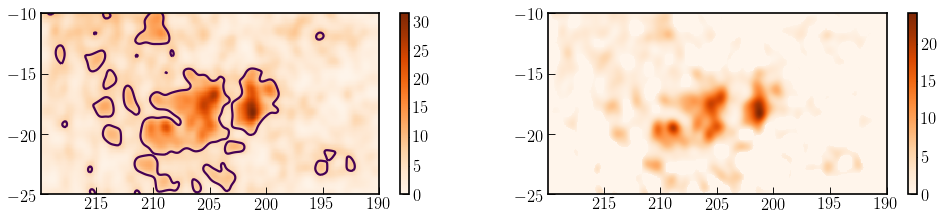

In [502]:
### And Plot

plt.figure(figsize=(15,3))

plt.subplot(121)
im  = plt.imshow(orion_density, origin = 'lower', aspect = 'auto',
                 vmin= 0., extent = [190, 220, -30, -5], cmap = 'Oranges')
thressSigma = plt.contour(Xsamples, Ysamples, normalized_density_tgas,
                          levels = [3], color ='k', linewidths = 2)
plt.axis([219.9, 190, -25, -10])
plt.colorbar(im)

plt.subplot(122)
im  = plt.imshow(normalized_density_tgas, origin = 'lower', aspect = 'auto',
                 vmin= 0., extent = [190, 220, -30, -5], cmap = 'Oranges', interpolation = 'gaussian')
plt.axis([219.9, 190, -25, -10])
plt.colorbar(im)

 Select sources within contours

In [437]:
XTGAS = np.vstack([lTGAS,bTGAS]).T
inside_contour = np.full((lTGAS.size), False, dtype= bool)
for coll in thressSigma.collections:
    for p in coll.get_paths():
        inside_contour  = inside_contour | p.contains_points(XTGAS)

In [438]:
prlx_overdensities = tgasPlx['parallax'][inside_contour]
print('Number of sources within the S=3 level:' ,prlx_overdensities.size)
print('Number of sources with $2. < \varpi < 3.5 \, \mathrm{mas}$',  tgasPlx.size)

Number of sources within the S=3 level: 776
Number of sources with $2. < arpi < 3.5 \, \mathrm{mas}$ 2503


In [440]:
### Save sources within the contours
tgasIn = tgasPlx[inside_contour]
fits.writeto('/data1/Data/Zari+17/tgas_inside_contour.fits', tgasInn)

### 2D Histogram in (Glon, Glat) 

In [118]:
binsx = np.linspace(190, 220, 30)
binsy = np.linspace(-30, -5, 25)

h = np.zeros((len(binsx)-1, len(binsy)-1))

for i in range(len(binsx) -1):
    for j in range(len(binsy)-1):
        w = np.where((tgasIn['l'] >= binsx[i]) & (tgasIn['l'] <= binsx[i+1]) & \
                    (tgasIn['b'] >= binsy[j]) & (tgasIn['b'] <= binsy[j+1]))
        
        plxAppo = tgasIn['parallax'][w]
        if len(plxAppo) > 0:
            h[i, j] = np.median(plxAppo)
        else:
            h[i, j] = 0.0

ONC distance:

I compute the distance in squares of 2deg x 2deg.

In [499]:
w = np.where((tgasIn['l'] > 208.06) & (tgasIn['l'] < 210.06) & (tgasIn['b'] > -20.65) & (tgasIn['b'] < -18.65) )
plxONC = (tgasIn[w])
print('Plx ONC:', np.median(plxONC['parallax']))
print('Number of stars in that position:', len(plxONC))
print('16th percentile:', np.percentile(plxONC['parallax'], 16.))
print('84th percentile:', np.percentile(plxONC['parallax'], 84.))

Plx ONC: 2.42173106286
Number of stars in that position: 37
16th percentile: 2.21267492889
84th percentile: 2.61691957258


$\epsilon Ori$ distance

In [500]:
w = np.where((tgasIn['l'] > 204.21) & (tgasIn['l'] < 206.21) & (tgasIn['b'] > -18.24) & (tgasIn['b'] < -16.24) )
plxEps = (tgasIn[w])
print(r'Plx epsilon Ori:', np.median(plxEps['parallax']))
print('Number of stars in that position:', len(plxEps))
print('16th percentile:', np.percentile(plxEps['parallax'], 16.))
print('84th percentile:', np.percentile(plxEps['parallax'], 84.))

Plx epsilon Ori: 2.75608591766
Number of stars in that position: 66
16th percentile: 2.41316890796
84th percentile: 3.09042012942


25 Ori distance

In [501]:
w = np.where((tgasIn['l'] > 199.946) & (tgasIn['l'] < 201.946) & (tgasIn['b'] > -19.3) & (tgasIn['b'] < -17.3) )
plx25 = (tgasIn[w])
print(r'Plx 25 Ori:', np.median(plx25['parallax']))
print('Number of stars in that position:', len(plx25))
print('16th percentile:', np.percentile(plx25['parallax'], 16.))
print('84th percentile:', np.percentile(plx25['parallax'], 84.))

Plx 25 Ori: 2.80837759542
Number of stars in that position: 59
16th percentile: 2.34753485382
84th percentile: 3.26500731712


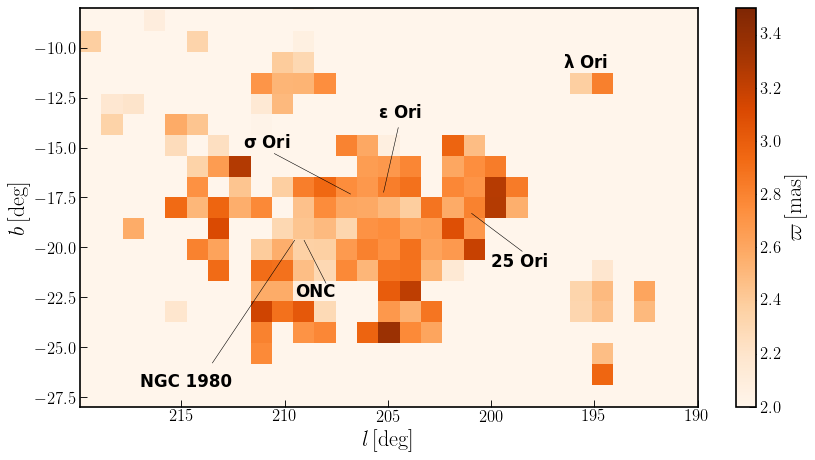

In [625]:
plt.figure(figsize = (11,6))
im = plt.imshow(np.rot90(h), interpolation='none',
                aspect = 'auto',
                extent=[190., 219.9, -30., -5], 
                vmin = 2., vmax = 3.5, cmap = 'Oranges')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\varpi \, [\mathrm{mas}]$', fontsize=20)

rc('text', usetex= False)
rc('font', family='sans-serif', weight = 'bold', size=15)
plt.text(200, -21., '25 Ori', color= 'k', fontsize = 15, family ='sans-serif')
plt.plot([198.5, 200.946],[-20.2, -18.3], 'k-', lw = 0.5)  
plt.text(205.5, -13.5, '$\mathrm{\epsilon}$ Ori', color = 'k', fontsize = 15, family ='sans-serif')
plt.plot([204.5, 205.21],[-14., -17.24], 'k-', lw = 0.5)
plt.text(212, -15., '$\mathrm{\sigma}$ Ori', color = 'k', fontsize = 15, family ='sans-serif')
plt.plot([210.5, 206.81], [-15.3, -17.33], 'k-', lw = 0.5)
plt.text(196.5, -11. , '$\mathrm{\lambda}$ Ori', color = 'k', fontsize = 15, family ='sans-serif')
plt.text(209.5, -22.5, 'ONC', color= 'k',fontsize = 15, family ='sans-serif')
plt.plot([208., 209.06], [-21.8, -19.65], 'k-', lw = 0.5)
plt.text(217., -27, 'NGC 1980', fontsize = 15, family ='sans-serif')
plt.plot([213.5, 209.52], [-25.8, -19.65], 'k-', lw = 0.5)



rc('text', usetex= True)
plt.axis([219.9, 190, -28, -8])
plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 20)
plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 20)
plt.tight_layout()


# Comparison stars-gas

See http://dustmaps.readthedocs.io/en/latest/index.html.

In [149]:
from dustmaps.bayestar import BayestarQuery
from dustmaps.sfd import SFDQuery
from dustmaps.planck import PlanckQuery
from dustmaps.config import config
config['data_dir'] = '/data1/'

In [150]:
### Create the grid
l0, b0 = (205., -15.)
lgrid = np.arange(l0 - 15., l0 + 15., 0.05)
bgrid = np.arange(b0 - 15., b0 + 15., 0.05)
lgrid, bgrid = np.meshgrid(lgrid, bgrid)
coords = SkyCoord(lgrid*units.deg, bgrid*units.deg,
                  distance=0.440*units.kpc, frame='galactic')


In [151]:
### Get the map

planck = PlanckQuery()
Av_planck = 2.742*planck(coords)

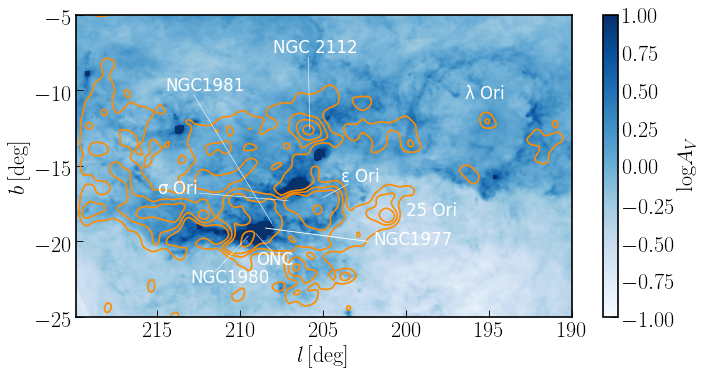

In [609]:
### Show

plt.figure(figsize=(10,5))
im = plt.imshow(
        np.log10(Av_planck)[::,::-1],
        extent = [lgrid.max(), lgrid.min(), bgrid.min(), bgrid.max()],
        origin='lower',
        interpolation='gaussian',
        cmap='Blues',
        aspect='auto', 
        vmin = -1., vmax= 1.,
    )

plt.contour(normalized_density, colors ='DarkOrange',
            extent=[xmin, xmax, ymin, ymax],
            levels = [1,2, 3, 6], lw = 3)


rc('text', usetex= False)
plt.text(213., -22.7, 'NGC1980', color = 'w', fontsize = 15, family ='sans-serif')
plt.plot([211.5, 209.52], [-22., -19.65], 'w-', lw = 0.5)
plt.text(214.5, -10., 'NGC1981', color = 'w', fontsize = 15, family ='sans-serif')
plt.plot([212.8, 208.09], [-10.3, -18.8 ], 'w-', lw =0.5)
plt.text(200, -18.29, '25 Ori', color = 'w', fontsize = 15, family ='sans-serif')
plt.text(204., -16., '$\mathrm{\epsilon}$ Ori',color = 'w', fontsize = 15, family ='sans-serif')
plt.plot([203.5, 205.],[-16.2, -17.1], 'w-', lw = 0.5)
plt.text(215, -16.8, '$\mathrm{\sigma}$ Ori', color = 'w',fontsize = 15, family ='sans-serif')
plt.plot([212.5, 207.1], [-16.8, -17.31], 'w-', lw = 0.5)
plt.text(196.5, -10.5 , '$\mathrm{\lambda}$ Ori', color ='w', fontsize = 15, family ='sans-serif')
plt.text(208, -7.5, 'NGC 2112', color = 'w', fontsize = 15, family ='sans-serif')
plt.plot([205.9, 205.8],[-7.8, -12.61], 'w-', lw = 0.5)
plt.text(209.06, -21.5, 'ONC', color = 'w',fontsize = 15, family ='sans-serif')
plt.plot([208.06, 209.06], [-20.7, -19.48], 'w-', lw = 0.5)
plt.text(202, -20.2 , 'NGC1977', fontsize = 15,color = 'w',family ='sans-serif')
plt.plot([202.3, 208.47], [-20., -19.12], 'w-', lw = 0.8)



rc('text', usetex= True)
clb = plt.colorbar(im)
clb.set_label(r'$\mathrm{log} A_V $', fontsize = 20)
plt.xlabel(r'$l \, \mathrm{[deg]}$', fontsize = 20)
plt.ylabel(r'$b \, \mathrm{[deg]}$', fontsize = 20)

plt.axis([219.9, 190, -25, -5])

